In [1]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from yahooquery import Ticker
import seaborn as sns
from scipy import stats

# Coleta dos dados

CSV retirado do site [fundamentus](https://fundamentus.com.br/detalhes.php)

Adicionalmente será utilizada a biblioteca [YahooQuery](https://yahooquery.dpguthrie.com/) para coleta de dados dinâmicos realacionados a cotação

> O período dos dados históricos obtidos é de **2018-10-13** a **2020-10-12**

In [2]:
# Fixando datas limite
END_DATE = datetime(2020, 10, 12)
START_DATE = END_DATE - timedelta(days=365 * 2)

TODAY = END_DATE - timedelta(days=180)
_6m = END_DATE - timedelta(days=360)

In [3]:
df = pd.read_csv('../data/2020_10_11_fundamentus.csv', index_col='ticker')

In [4]:
df.replace([np.inf, -np.inf], np.nan)
df.head()

,ATIVO,DIV_BRUTA,DISPONIBILIDADES,DIV_LIQUIDA,ATIVO_CIRCULANTE,PATRIM_LIQ,RECEITA_LIQUIDA,EBIT,LUCRO_LIQUIDO,NRO_ACOES,CRES_REC_(5A),ROIC,LIQUIDEZ_CORR,SETOR,SUBSETOR,DEPOSITOS,CART_DE_CREDITO,RESULT_INT_FINANC,REC_SERVICOS
ticker,,,,,,,,,,,,,,,,,,,
AALR3,2.618910e+09,9.017330e+08,3.253200e+08,5.764130e+08,6.355580e+08,1.179760e+09,9.147390e+08,-2.432000e+06,-8.448000e+07,1.182930e+08,-0.040,-0.001,0.87,SAUDE,SERVICOS_MEDICO_-_HOSPITALARES_ANALISES_E_DIAG...,NaN,NaN,NaN,NaN
ABCB3,4.989580e+10,NaN,NaN,NaN,NaN,4.093300e+09,NaN,NaN,4.187330e+08,2.183590e+08,0.028,NaN,NaN,FINANCEIROS,BANCOS,7.325720e+09,1.768990e+10,-5453950.0,292984000.0
ABCB4,4.989580e+10,NaN,NaN,NaN,NaN,4.093300e+09,NaN,NaN,4.187330e+08,2.183590e+08,0.028,NaN,NaN,FINANCEIROS,BANCOS,7.325720e+09,1.768990e+10,-5453950.0,292984000.0
ABEV3,1.213930e+11,6.782830e+09,1.748380e+10,-1.070090e+10,3.626810e+10,7.392280e+10,5.203240e+10,1.322820e+10,8.915960e+09,1.573510e+10,0.030,0.146,1.24,BEBIDAS,CERVEJAS_E_REFRIGERANTES,NaN,NaN,NaN,NaN
ABYA3,9.782870e+08,3.831590e+08,2.955600e+07,3.536030e+08,4.982220e+08,2.920600e+08,2.506570e+08,2.580200e+07,-2.398000e+06,1.049060e+08,0.164,0.028,2.09,CONSTRUCAO_E_ENGENHARIA,CONSTRUCAO_CIVIL,NaN,NaN,NaN,NaN


In [5]:
df.shape

(906, 19)

In [6]:
df.dtypes

ATIVO                float64
DIV_BRUTA            float64
DISPONIBILIDADES     float64
DIV_LIQUIDA          float64
ATIVO_CIRCULANTE     float64
PATRIM_LIQ           float64
RECEITA_LIQUIDA      float64
EBIT                 float64
LUCRO_LIQUIDO        float64
NRO_ACOES            float64
CRES_REC_(5A)        float64
ROIC                 float64
LIQUIDEZ_CORR        float64
SETOR                 object
SUBSETOR              object
DEPOSITOS            float64
CART_DE_CREDITO      float64
RESULT_INT_FINANC    float64
REC_SERVICOS         float64
dtype: object

### Adicionando indicadores fundamentalistas em função da cotação atual

O método `Ticker.summary_detail` retorna uma série de atributos referentes a cotação do papel em questão. O crawler do fundamentus ainda retorna algums papéis que já tiveram sua *Oferta Pública de Aquisição* (OPA) e/ou não estão mais na B3

É necessário filtrar esses ativos com ajuda da classe `Ticker`

In [7]:
# https://yahooquery.dpguthrie.com/guide/ticker/intro/
import multiprocessing

threads = multiprocessing.cpu_count()
print(f'# of threads: {threads}')

tickers = Ticker(' '.join(f'{ticker}.SA' for ticker in df.index), asynchronous=True,
                 max_workers=threads, progress=True, timeout=60*10)

# of threads: 12


In [8]:
%%time

history = tickers.history(period='max', end=END_DATE, interval='1d')

if isinstance(history, dict):
    history = {k.replace('.SA', ''): v for k, v in history.items() if isinstance(k, str)}
    
    valid_tickers = [k
                     for k, v in history.items()
                     if isinstance(v, pd.DataFrame)]
elif isinstance(history, pd.DataFrame):
    history = {t.replace('.SA', ''): history.loc[f'{t}.SA']
               for t in history.index}
    valid_tickers = [k for k in history.index]
    
    
tickers = Ticker(' '.join(f'{ticker}.SA' for ticker in valid_tickers), asynchronous=True,
                 max_workers=threads, progress=True)

len(valid_tickers)

CPU times: user 18.1 s, sys: 1.02 s, total: 19.1 s
Wall time: 29.6 s


479

In [9]:
df_clean = df.loc[[t for t in df.index if t in valid_tickers],:]
df_clean.shape

(479, 19)

In [10]:
PRECO_FINAL = f'PRECO_{END_DATE.strftime("%Y_%m_%d")}' # target
PRECO_HOJE = f'PRECO_{TODAY.strftime("%Y_%m_%d")}'
PRECO_6m = f'PRECO_{_6m.strftime("%Y_%m_%d")}'

In [11]:
def cotacao_hoje(row):
    try:
        return history[row.name]['close'].loc[TODAY.date()]
    except KeyError as e:
        return np.nan

df_clean[PRECO_HOJE] = df_clean.apply(cotacao_hoje, axis=1)
df_clean.dropna(subset=[PRECO_HOJE], inplace=True)

len(df_clean)

443

In [12]:
df_clean.head()

,ATIVO,DIV_BRUTA,DISPONIBILIDADES,DIV_LIQUIDA,ATIVO_CIRCULANTE,PATRIM_LIQ,RECEITA_LIQUIDA,EBIT,LUCRO_LIQUIDO,NRO_ACOES,CRES_REC_(5A),ROIC,LIQUIDEZ_CORR,SETOR,SUBSETOR,DEPOSITOS,CART_DE_CREDITO,RESULT_INT_FINANC,REC_SERVICOS,PRECO_2020_04_15
ticker,,,,,,,,,,,,,,,,,,,,
AALR3,2.618910e+09,9.017330e+08,3.253200e+08,5.764130e+08,6.355580e+08,1.179760e+09,9.147390e+08,-2.432000e+06,-8.448000e+07,1.182930e+08,-0.040,-0.001,0.87,SAUDE,SERVICOS_MEDICO_-_HOSPITALARES_ANALISES_E_DIAG...,NaN,NaN,NaN,NaN,10.21
ABCB4,4.989580e+10,NaN,NaN,NaN,NaN,4.093300e+09,NaN,NaN,4.187330e+08,2.183590e+08,0.028,NaN,NaN,FINANCEIROS,BANCOS,7.325720e+09,1.768990e+10,-5453950.0,292984000.0,14.07
ABEV3,1.213930e+11,6.782830e+09,1.748380e+10,-1.070090e+10,3.626810e+10,7.392280e+10,5.203240e+10,1.322820e+10,8.915960e+09,1.573510e+10,0.030,0.146,1.24,BEBIDAS,CERVEJAS_E_REFRIGERANTES,NaN,NaN,NaN,NaN,11.91
ADHM3,2.420000e+05,0.000000e+00,0.000000e+00,0.000000e+00,2.300000e+04,-1.977600e+07,3.300000e+04,-4.471000e+06,-6.224000e+06,1.630800e+07,0.435,5.217,0.00,PRODS_DE_USO_PESSOAL_E_DE_LIMPEZA,PRODUTOS_DE_USO_PESSOAL,NaN,NaN,NaN,NaN,2.40
AFLT3,2.367050e+08,8.830000e+05,6.404200e+07,-6.315900e+07,8.776500e+07,2.253200e+08,3.845600e+07,2.344000e+07,2.376300e+07,6.308500e+07,0.107,0.136,20.69,ENERGIA_ELETRICA,ENERGIA_ELETRICA,NaN,NaN,NaN,NaN,7.63


Calculando os indicadores fundamentalistas

In [13]:
# LPA: Lucro por Acoes
df_clean['LPA'] = df_clean['LUCRO_LIQUIDO'] / df_clean['NRO_ACOES']

# VPA: Valor Patrimonial por Acao
df_clean['VPA'] = df_clean['PATRIM_LIQ'] / df_clean['NRO_ACOES']

# P/L: Preço sobre Lucro
df_clean['P/L'] = df_clean[PRECO_HOJE] / df_clean['LPA']

# P/VPA: Preço sobre Valor Patrimonial
df_clean['P/VP'] = df_clean[PRECO_HOJE] / df_clean['VPA']

# P/EBIT: Preço sobre EBIT
df_clean['P/EBIT'] = df_clean[PRECO_HOJE] / (df_clean['EBIT'] / df_clean['NRO_ACOES'])

# MARKET_CAP: valor total das acoes ou valor de mercado
df_clean['MARKET_CAP'] = df_clean[PRECO_HOJE] * df_clean['NRO_ACOES']

# EV: Enterprise Value == market cap + divida liquida
df_clean['EV'] = df_clean['MARKET_CAP'] + df_clean['DIV_LIQUIDA']

# EV/EBIT: Enterprise Value sobre EBIT
df_clean['EV/EBIT'] = df_clean['EV'] / df_clean['EBIT']

# MARGEM_EBIT: EBIT/RECEITA_LIQUIDA
df_clean['MARGEM_EBIT'] = df_clean['EBIT'] / df_clean['RECEITA_LIQUIDA']

# MARGEM_LIQUIDA: LUCRO_LIQUIDO/RECEITA_LIQUIDA
df_clean['MARGEM_LIQUIDA'] = df_clean['LUCRO_LIQUIDO'] / df_clean['RECEITA_LIQUIDA']

# ROE: LUCRO_LIQUIDO/PATRIM_LIQ
df_clean['ROE'] = df_clean['LUCRO_LIQUIDO'] / df_clean['PATRIM_LIQ']

# DIV_LIQ/PATR_LIQ
df_clean['DIV_LIQ/PATR_LIQ'] = df_clean['DIV_LIQUIDA'] / df_clean['PATRIM_LIQ']

In [14]:
df_clean.loc['ITSA4'] # Exemplo de Itausa, holding a que pertence o Itau

ATIVO                 6.5814e+10
DIV_BRUTA              4.981e+09
DISPONIBILIDADES       3.821e+09
DIV_LIQUIDA             1.16e+09
ATIVO_CIRCULANTE       6.799e+09
PATRIM_LIQ            5.2896e+10
RECEITA_LIQUIDA        5.002e+09
EBIT                    1.77e+08
LUCRO_LIQUIDO          7.001e+09
NRO_ACOES            8.41081e+09
CRES_REC_(5A)              0.014
ROIC                       0.003
LIQUIDEZ_CORR               2.36
SETOR                FINANCEIROS
SUBSETOR                  BANCOS
DEPOSITOS                    NaN
CART_DE_CREDITO              NaN
RESULT_INT_FINANC            NaN
REC_SERVICOS                 NaN
PRECO_2020_04_15             9.3
LPA                     0.832381
VPA                      6.28905
P/L                      11.1728
P/VP                     1.47876
P/EBIT                   441.924
MARKET_CAP           7.82205e+10
EV                   7.93805e+10
EV/EBIT                  448.478
MARGEM_EBIT            0.0353858
MARGEM_LIQUIDA           1.39964
ROE       

# Definição de tipos

Dessa forma temos um dataset construido, com possibilidade de ter os dados de balanço patrimonial atualizados através do crawler e os dados de mercado através da api yahooquery

O dataset final tem 32 atributos, sendo 30 numéricos e 2 categóricos como mostrado abaixo

In [15]:
acoes = df_clean
# mudando o tipo de setor e subsetor de antemão
acoes['SETOR'] = acoes['SETOR'].astype('category')
acoes['SUBSETOR'] = acoes['SUBSETOR'].astype('category')
acoes.shape

(443, 32)

In [16]:
acoes.dtypes

ATIVO                 float64
DIV_BRUTA             float64
DISPONIBILIDADES      float64
DIV_LIQUIDA           float64
ATIVO_CIRCULANTE      float64
PATRIM_LIQ            float64
RECEITA_LIQUIDA       float64
EBIT                  float64
LUCRO_LIQUIDO         float64
NRO_ACOES             float64
CRES_REC_(5A)         float64
ROIC                  float64
LIQUIDEZ_CORR         float64
SETOR                category
SUBSETOR             category
DEPOSITOS             float64
CART_DE_CREDITO       float64
RESULT_INT_FINANC     float64
REC_SERVICOS          float64
PRECO_2020_04_15      float64
LPA                   float64
VPA                   float64
P/L                   float64
P/VP                  float64
P/EBIT                float64
MARKET_CAP            float64
EV                    float64
EV/EBIT               float64
MARGEM_EBIT           float64
MARGEM_LIQUIDA        float64
ROE                   float64
DIV_LIQ/PATR_LIQ      float64
dtype: object

# Tratamento de dados ausentes

- É possível perceber que há uma divisão entre pelo menos dois tipos distintos de ações, provavelmente entre empresas do subsetor bancário e as outras.

In [17]:
acoes.isna().sum()

ATIVO                  0
DIV_BRUTA             41
DISPONIBILIDADES      41
DIV_LIQUIDA           41
ATIVO_CIRCULANTE      41
PATRIM_LIQ             0
RECEITA_LIQUIDA       41
EBIT                  41
LUCRO_LIQUIDO          0
NRO_ACOES              0
CRES_REC_(5A)         25
ROIC                  62
LIQUIDEZ_CORR         62
SETOR                  1
SUBSETOR               1
DEPOSITOS            402
CART_DE_CREDITO      402
RESULT_INT_FINANC    402
REC_SERVICOS         402
PRECO_2020_04_15       0
LPA                    0
VPA                    0
P/L                    0
P/VP                   0
P/EBIT                41
MARKET_CAP             0
EV                    41
EV/EBIT               41
MARGEM_EBIT           45
MARGEM_LIQUIDA        45
ROE                    4
DIV_LIQ/PATR_LIQ      45
dtype: int64

<AxesSubplot:>

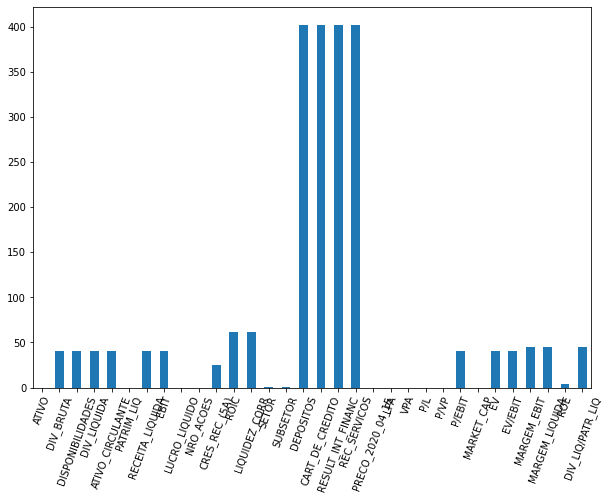

In [18]:
acoes.isna().sum().plot.bar(rot=70, figsize=(10, 7))

(52, 32)
(52, 32)


<AxesSubplot:>

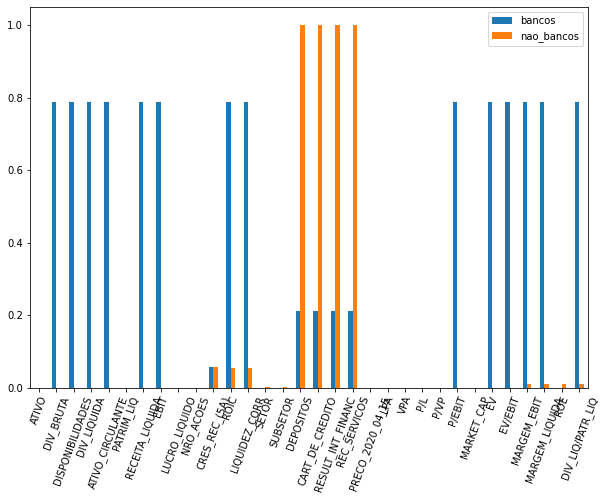

In [19]:
bancos = acoes[acoes['SUBSETOR'].isin(['BANCOS', 'SOC_CREDITO_E_FINANCIAMENTO'])]
print(bancos.shape)

comuns = acoes[~acoes['SUBSETOR'].isin(['BANCOS', 'SOC_CREDITO_E_FINANCIAMENTO'])]
print(bancos.shape)

pd.DataFrame({'bancos':bancos.isna().sum()/len(bancos), 'nao_bancos':comuns.isna().sum()/len(comuns)}).plot.bar(rot=70, figsize=(10, 7))

A estratégia de inputação dos dados ausentes aqui vai se basear no subsetor de cada ativo, mais especificamente nessa divisião entre setor bancário/outros setores.

Para os que pertencem ao setor bancário, os atributos que são característicos desse setor (`DEPOSITOS`, `CART_DE_CREDITO`, etc) serão imputados com zero juntamente com os que não pertencem a esse setor pois são apenas 3 empresas (`BRGE`, `ITSA`, `RPAD`), que na verdade são holdings ou consórcios financeiros que possuem valores ausentes, então serão tratadas como empresas comuns.
O contrário também será aplicado.

In [20]:
# AS EMPRESAS QUE ESTAO NO SUBSETOR BANCARIO E POSSUEM VALORES AUSENTES PARA ATRIBUTOS
# CARACTERISTICOS DESSE SUBSETOR SÃO APENAS 3
bancos[(bancos['DEPOSITOS'].isna()) | (bancos['CART_DE_CREDITO'].isna())
       | (bancos['RESULT_INT_FINANC'].isna()) | (bancos['REC_SERVICOS'].isna())].index

Index(['BRGE11', 'BRGE12', 'BRGE3', 'BRGE5', 'BRGE6', 'BRGE8', 'ITSA3',
       'ITSA4', 'RPAD3', 'RPAD5', 'RPAD6'],
      dtype='object', name='ticker')

In [21]:
attrs_bancos = ['DEPOSITOS', 'CART_DE_CREDITO', 'RESULT_INT_FINANC', 'REC_SERVICOS']

bancos[attrs_bancos] = bancos[attrs_bancos].fillna(value=0)
comuns[attrs_bancos] = comuns[attrs_bancos].fillna(value=0)


attrs_comuns = ['DIV_BRUTA', 'DISPONIBILIDADES', 'DIV_LIQUIDA', 'ATIVO_CIRCULANTE', 'PATRIM_LIQ',
                'RECEITA_LIQUIDA', 'EBIT', 'ROIC', 'LIQUIDEZ_CORR', 'P/EBIT', 'EV', 'EV/EBIT',
                'MARGEM_EBIT', 'MARGEM_LIQUIDA', 'DIV_LIQ/PATR_LIQ']

bancos[attrs_comuns] = bancos[attrs_comuns].fillna(value=0)

/home/adilson/.anaconda3/envs/if697/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


<AxesSubplot:>

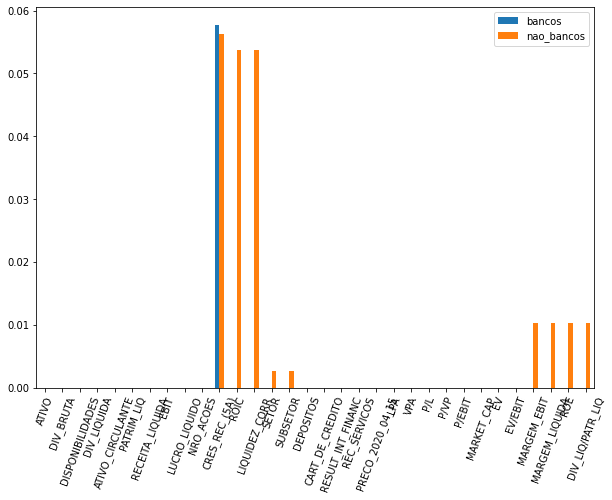

In [22]:
pd.DataFrame(
    {'bancos': bancos.isna().sum()/len(bancos), 'nao_bancos': comuns.isna().sum()/len(comuns)}
).plot.bar(rot=70, figsize=(10, 7))

In [23]:
acoes = pd.concat([bancos, comuns])

<AxesSubplot:>

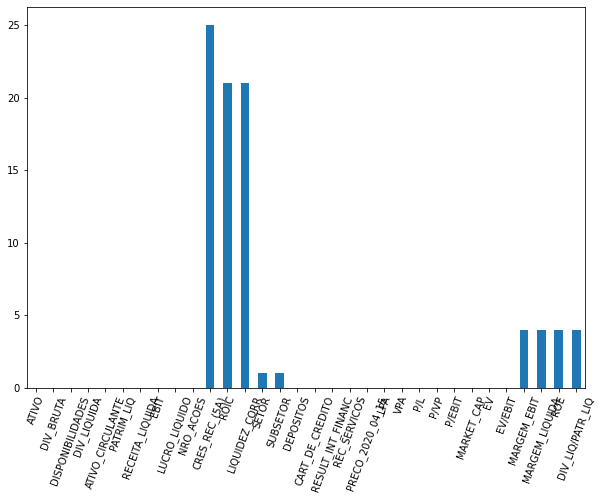

In [24]:
acoes.isna().sum().plot.bar(rot=70, figsize=(10, 7))

**Para valores ausentes restantes** será utilizado o **KNNImputer** do sklearn, e para isso é preciso codificar numericamente os atributos categóricos e normalizar os valores para a extensão dos atributos não influenciar o cálculo da distância no KNN

In [25]:
# One hot encoding com .get_dummies
acoes_c = pd.get_dummies(acoes, drop_first=True)
acoes_c = acoes_c.replace([np.inf, -np.inf], np.nan)
acoes_c.head()

,ATIVO,DIV_BRUTA,DISPONIBILIDADES,DIV_LIQUIDA,ATIVO_CIRCULANTE,PATRIM_LIQ,RECEITA_LIQUIDA,EBIT,LUCRO_LIQUIDO,NRO_ACOES,...,SUBSETOR_TECIDOS_VESTUARIO_E_CALCADOS,SUBSETOR_TELEFONIA_FIXA,SUBSETOR_TELEFONIA_MOVEL,SUBSETOR_TRANSPORTE_AEREO,SUBSETOR_TRANSPORTE_FERROVIARIO,SUBSETOR_TRANSPORTE_HIDROVIARIO,SUBSETOR_TRANSPORTE_RODOVIARIO,SUBSETOR_UTENSILIOS_DOMESTICOS,SUBSETOR_VESTUARIO,SUBSETOR_VIAGENS_E_TURISMO
ticker,,,,,,,,,,,,,,,,,,,,,
ABCB4,4.989580e+10,0.0,0.0,0.0,0.0,4.093300e+09,0.0,0.0,4.187330e+08,2.183590e+08,...,0,0,0,0,0,0,0,0,0,0
BAZA3,2.051230e+10,0.0,0.0,0.0,0.0,2.316530e+09,0.0,0.0,3.250920e+08,2.964600e+07,...,0,0,0,0,0,0,0,0,0,0
BBAS3,1.780470e+12,0.0,0.0,0.0,0.0,1.050070e+11,0.0,0.0,1.612730e+10,2.865420e+09,...,0,0,0,0,0,0,0,0,0,0
BBDC3,1.329520e+12,0.0,0.0,0.0,0.0,1.351340e+11,0.0,0.0,1.760820e+10,8.870210e+09,...,0,0,0,0,0,0,0,0,0,0
BBDC4,1.329520e+12,0.0,0.0,0.0,0.0,1.351340e+11,0.0,0.0,1.760820e+10,8.870210e+09,...,0,0,0,0,0,0,0,0,0,0


In [26]:
acoes_norm = (acoes_c - acoes_c.min()) / (acoes_c.max() - acoes_c.min())
acoes_norm.head()

,ATIVO,DIV_BRUTA,DISPONIBILIDADES,DIV_LIQUIDA,ATIVO_CIRCULANTE,PATRIM_LIQ,RECEITA_LIQUIDA,EBIT,LUCRO_LIQUIDO,NRO_ACOES,...,SUBSETOR_TECIDOS_VESTUARIO_E_CALCADOS,SUBSETOR_TELEFONIA_FIXA,SUBSETOR_TELEFONIA_MOVEL,SUBSETOR_TRANSPORTE_AEREO,SUBSETOR_TRANSPORTE_FERROVIARIO,SUBSETOR_TRANSPORTE_HIDROVIARIO,SUBSETOR_TRANSPORTE_RODOVIARIO,SUBSETOR_UTENSILIOS_DOMESTICOS,SUBSETOR_VESTUARIO,SUBSETOR_VIAGENS_E_TURISMO
ticker,,,,,,,,,,,,,,,,,,,,,
ABCB4,0.028024,0.0,0.0,0.033805,0.0,0.066841,0.00077,0.031023,0.638280,0.013876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BAZA3,0.011521,0.0,0.0,0.033805,0.0,0.059894,0.00077,0.031023,0.636544,0.001883,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBAS3,1.000000,0.0,0.0,0.033805,0.0,0.461392,0.00077,0.031023,0.929623,0.182103,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBDC3,0.746724,0.0,0.0,0.033805,0.0,0.579182,0.00077,0.031023,0.957088,0.563721,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBDC4,0.746724,0.0,0.0,0.033805,0.0,0.579182,0.00077,0.031023,0.957088,0.563721,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(missing_values=np.nan, n_neighbors=5)

In [28]:
acoes_one_hot = pd.DataFrame(imputer.fit_transform(acoes_norm), index=acoes_norm.index, columns=acoes_norm.columns)

Desfazendo a normalização

In [29]:
acoes_one_hot = acoes_one_hot * (acoes_c.max() - acoes_c.min()) + acoes_c.min()

In [30]:
acoes_one_hot.head()

,ATIVO,DIV_BRUTA,DISPONIBILIDADES,DIV_LIQUIDA,ATIVO_CIRCULANTE,PATRIM_LIQ,RECEITA_LIQUIDA,EBIT,LUCRO_LIQUIDO,NRO_ACOES,...,SUBSETOR_TECIDOS_VESTUARIO_E_CALCADOS,SUBSETOR_TELEFONIA_FIXA,SUBSETOR_TELEFONIA_MOVEL,SUBSETOR_TRANSPORTE_AEREO,SUBSETOR_TRANSPORTE_FERROVIARIO,SUBSETOR_TRANSPORTE_HIDROVIARIO,SUBSETOR_TRANSPORTE_RODOVIARIO,SUBSETOR_UTENSILIOS_DOMESTICOS,SUBSETOR_VESTUARIO,SUBSETOR_VIAGENS_E_TURISMO
ticker,,,,,,,,,,,,,,,,,,,,,
ABCB4,4.989580e+10,0.0,0.0,0.0,0.0,4.093300e+09,0.0,0.0,4.187330e+08,2.183590e+08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BAZA3,2.051230e+10,0.0,0.0,0.0,0.0,2.316530e+09,0.0,0.0,3.250920e+08,2.964600e+07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBAS3,1.780470e+12,0.0,0.0,0.0,0.0,1.050070e+11,0.0,0.0,1.612730e+10,2.865420e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBDC3,1.329520e+12,0.0,0.0,0.0,0.0,1.351340e+11,0.0,0.0,1.760820e+10,8.870210e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBDC4,1.329520e+12,0.0,0.0,0.0,0.0,1.351340e+11,0.0,0.0,1.760820e+10,8.870210e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# sem valores vazios :)

acoes_one_hot.isna().sum()[acoes_one_hot.isna().sum() > 0]

Series([], dtype: int64)

In [32]:
# desfazendo one hot encoding
acoes_full = acoes_one_hot.copy()
acoes_full['SETOR'] = acoes['SETOR'].astype('category')
acoes_full['SUBSETOR'] = acoes['SUBSETOR'].astype('category')

acoes_full = acoes_full.drop(columns=[col for col in acoes_full if col.startswith('SETOR_') or col.startswith('SUBSETOR_')])

In [33]:
acoes_full.head()

,ATIVO,DIV_BRUTA,DISPONIBILIDADES,DIV_LIQUIDA,ATIVO_CIRCULANTE,PATRIM_LIQ,RECEITA_LIQUIDA,EBIT,LUCRO_LIQUIDO,NRO_ACOES,...,P/EBIT,MARKET_CAP,EV,EV/EBIT,MARGEM_EBIT,MARGEM_LIQUIDA,ROE,DIV_LIQ/PATR_LIQ,SETOR,SUBSETOR
ticker,,,,,,,,,,,,,,,,,,,,,
ABCB4,4.989580e+10,0.0,0.0,0.0,0.0,4.093300e+09,0.0,0.0,4.187330e+08,2.183590e+08,...,0.0,3.072311e+09,0.0,0.0,0.0,-5.684342e-14,0.102297,3.552714e-15,FINANCEIROS,BANCOS
BAZA3,2.051230e+10,0.0,0.0,0.0,0.0,2.316530e+09,0.0,0.0,3.250920e+08,2.964600e+07,...,0.0,8.893800e+08,0.0,0.0,0.0,-5.684342e-14,0.140336,3.552714e-15,FINANCEIROS,BANCOS
BBAS3,1.780470e+12,0.0,0.0,0.0,0.0,1.050070e+11,0.0,0.0,1.612730e+10,2.865420e+09,...,0.0,8.495970e+10,0.0,0.0,0.0,-5.684342e-14,0.153583,3.552714e-15,FINANCEIROS,BANCOS
BBDC3,1.329520e+12,0.0,0.0,0.0,0.0,1.351340e+11,0.0,0.0,1.760820e+10,8.870210e+09,...,0.0,1.685340e+11,0.0,0.0,0.0,-5.684342e-14,0.130302,3.552714e-15,FINANCEIROS,BANCOS
BBDC4,1.329520e+12,0.0,0.0,0.0,0.0,1.351340e+11,0.0,0.0,1.760820e+10,8.870210e+09,...,0.0,1.818393e+11,0.0,0.0,0.0,-5.684342e-14,0.130302,3.552714e-15,FINANCEIROS,BANCOS


# Limpeza dos dados


### Univariados

Analisando atributo comum aos dois tipos de ações citados anteriormente

ShapiroResult(statistic=nan, pvalue=1.0)

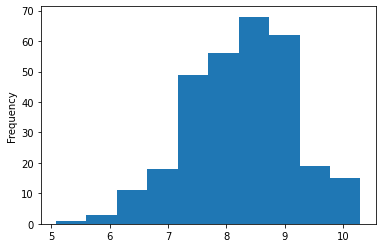

In [34]:
acoes_full['LUCRO_LIQUIDO'].apply(np.log10).plot.hist()
stats.shapiro(acoes_full['LUCRO_LIQUIDO'].apply(np.log10))

In [35]:
LL_log = acoes_full['LUCRO_LIQUIDO'].apply(np.log10)
mad = abs(LL_log - LL_log.median()).median() / .6745
acoes_full[abs(LL_log - LL_log.median()) / mad > 3.5]

,ATIVO,DIV_BRUTA,DISPONIBILIDADES,DIV_LIQUIDA,ATIVO_CIRCULANTE,PATRIM_LIQ,RECEITA_LIQUIDA,EBIT,LUCRO_LIQUIDO,NRO_ACOES,...,P/EBIT,MARKET_CAP,EV,EV/EBIT,MARGEM_EBIT,MARGEM_LIQUIDA,ROE,DIV_LIQ/PATR_LIQ,SETOR,SUBSETOR
ticker,,,,,,,,,,,,,,,,,,,,,


<AxesSubplot:ylabel='Frequency'>

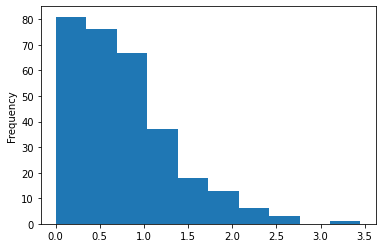

In [36]:
(abs(LL_log - LL_log.median()) / mad).plot.hist()

### Bivariados

Analisando a relação Margem Líquida - Dívida Líquida/Patrimônio Líquido. Idealmente, quando maior a Margem Líquida e menor a Dívida Líquida/Patrimônio Líquido, melhor.

In [37]:
stats.shapiro(acoes_full['DIV_LIQ/PATR_LIQ'].apply(np.log10))

ShapiroResult(statistic=nan, pvalue=1.0)

In [38]:
stats.shapiro(acoes_full['MARGEM_LIQUIDA'].apply(np.log10))

ShapiroResult(statistic=nan, pvalue=1.0)

<AxesSubplot:xlabel='MARGEM_LIQUIDA', ylabel='DIV_LIQ/PATR_LIQ'>

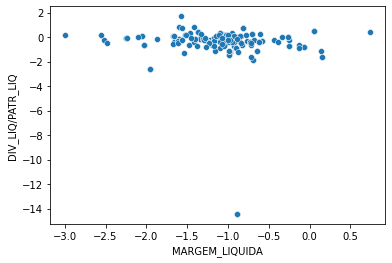

In [39]:
sns.scatterplot(x=acoes_full['MARGEM_LIQUIDA'].apply(np.log10), y=acoes_full['DIV_LIQ/PATR_LIQ'].apply(np.log10))

Nesse caso os outliers seriam de interesse, como é o caso de Itaúsa abaixo

In [40]:
acoes_full[(acoes_full['MARGEM_LIQUIDA'].apply(np.log10) > .1) & (acoes_full['DIV_LIQ/PATR_LIQ'].apply(np.log10) < 0)]

,ATIVO,DIV_BRUTA,DISPONIBILIDADES,DIV_LIQUIDA,ATIVO_CIRCULANTE,PATRIM_LIQ,RECEITA_LIQUIDA,EBIT,LUCRO_LIQUIDO,NRO_ACOES,...,P/EBIT,MARKET_CAP,EV,EV/EBIT,MARGEM_EBIT,MARGEM_LIQUIDA,ROE,DIV_LIQ/PATR_LIQ,SETOR,SUBSETOR
ticker,,,,,,,,,,,,,,,,,,,,,
ITSA3,6.581400e+10,4.981000e+09,3.821000e+09,1.160000e+09,6.799000e+09,5.289600e+10,5.002000e+09,177000000.0,7.001000e+09,8.410810e+09,...,514.152326,9.100496e+10,9.216496e+10,520.705998,0.035386,1.399640,0.132354,0.021930,FINANCEIROS,BANCOS
ITSA4,6.581400e+10,4.981000e+09,3.821000e+09,1.160000e+09,6.799000e+09,5.289600e+10,5.002000e+09,177000000.0,7.001000e+09,8.410810e+09,...,441.923924,7.822053e+10,7.938053e+10,448.477597,0.035386,1.399640,0.132354,0.021930,FINANCEIROS,BANCOS
BRPR3,9.916320e+09,1.759630e+09,1.255720e+09,5.039120e+08,1.517320e+09,7.166500e+09,3.342860e+08,217616000.0,4.564880e+08,4.915100e+08,...,20.282330,4.413760e+09,4.917672e+09,22.597932,0.650987,1.365561,0.063697,0.070315,EXPLORACAO_DE_IMOVEIS,EXPLORACAO_DE_IMOVEIS



### Multivariados
Ainda temos 147 atributos depois do *one hot encoding*

Para detectar outliers com esse número de features será utilizado o Isolation Forest e o Local Outlier Factor, já que eles não são paramétricos

In [41]:
from sklearn.ensemble import IsolationForest

In [42]:
iforest = IsolationForest(contamination=.01, random_state=0)
acoes_one_hot[pd.Series(iforest.fit_predict(acoes_one_hot), index=acoes_one_hot.index) == -1]

,ATIVO,DIV_BRUTA,DISPONIBILIDADES,DIV_LIQUIDA,ATIVO_CIRCULANTE,PATRIM_LIQ,RECEITA_LIQUIDA,EBIT,LUCRO_LIQUIDO,NRO_ACOES,...,SUBSETOR_TECIDOS_VESTUARIO_E_CALCADOS,SUBSETOR_TELEFONIA_FIXA,SUBSETOR_TELEFONIA_MOVEL,SUBSETOR_TRANSPORTE_AEREO,SUBSETOR_TRANSPORTE_FERROVIARIO,SUBSETOR_TRANSPORTE_HIDROVIARIO,SUBSETOR_TRANSPORTE_RODOVIARIO,SUBSETOR_UTENSILIOS_DOMESTICOS,SUBSETOR_VESTUARIO,SUBSETOR_VIAGENS_E_TURISMO
ticker,,,,,,,,,,,,,,,,,,,,,
BBDC3,1.329520e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.351340e+11,0.000000e+00,0.000000e+00,1.760820e+10,8.870210e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBDC4,1.329520e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.351340e+11,0.000000e+00,0.000000e+00,1.760820e+10,8.870210e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PETR3,1.015140e+12,4.995550e+11,1.095500e+11,3.900050e+11,2.019260e+11,2.427660e+11,2.760460e+11,8.545400e+10,-3.399600e+10,1.304450e+10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PETR4,1.015140e+12,4.995550e+11,1.095500e+11,3.900050e+11,2.019260e+11,2.427660e+11,2.760460e+11,8.545400e+10,-3.399600e+10,1.304450e+10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VALE3,4.553030e+11,1.016080e+11,6.633310e+10,3.527500e+10,1.111950e+11,1.869590e+11,1.533680e+11,6.342340e+10,6.407460e+09,5.284470e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=25, contamination=0.01)

acoes_one_hot[pd.Series(lof.fit_predict(acoes_one_hot), index=acoes_one_hot.index) == -1]

,ATIVO,DIV_BRUTA,DISPONIBILIDADES,DIV_LIQUIDA,ATIVO_CIRCULANTE,PATRIM_LIQ,RECEITA_LIQUIDA,EBIT,LUCRO_LIQUIDO,NRO_ACOES,...,SUBSETOR_TECIDOS_VESTUARIO_E_CALCADOS,SUBSETOR_TELEFONIA_FIXA,SUBSETOR_TELEFONIA_MOVEL,SUBSETOR_TRANSPORTE_AEREO,SUBSETOR_TRANSPORTE_FERROVIARIO,SUBSETOR_TRANSPORTE_HIDROVIARIO,SUBSETOR_TRANSPORTE_RODOVIARIO,SUBSETOR_UTENSILIOS_DOMESTICOS,SUBSETOR_VESTUARIO,SUBSETOR_VIAGENS_E_TURISMO
ticker,,,,,,,,,,,,,,,,,,,,,
BBAS3,1.780470e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.050070e+11,0.000000e+00,0.000000e+00,1.612730e+10,2.865420e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBDC3,1.329520e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.351340e+11,0.000000e+00,0.000000e+00,1.760820e+10,8.870210e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBDC4,1.329520e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.351340e+11,0.000000e+00,0.000000e+00,1.760820e+10,8.870210e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PETR3,1.015140e+12,4.995550e+11,1.095500e+11,3.900050e+11,2.019260e+11,2.427660e+11,2.760460e+11,8.545400e+10,-3.399600e+10,1.304450e+10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PETR4,1.015140e+12,4.995550e+11,1.095500e+11,3.900050e+11,2.019260e+11,2.427660e+11,2.760460e+11,8.545400e+10,-3.399600e+10,1.304450e+10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Dada a relevância dos ativos dados como outliers pelos métodos utilizados acima, não será feita a remoção desses outliers do dataset pois outliers nesse domínio são bem-vindos

# Estatísticas Descritivas

Para análise fundamentalista os ativos mais interessantes são aqueles que pertencem a empresas sólidas e pagam bons dividendos

Os indicadores financeiros que medem a saúde financeira de uma empresa, assim como sua rentabilidade são:

- ROE (Return on Equity);
    - Quanto de lucro uma empresa gera pra cada Real próprio investido nela

- ROIC (Return on Invested Capital);
    - Quanto de lucro uma empresa gera pra cada Real próprio e de terceiros investido nela
    
- Dívida Líquida sobre Patrimônio Liquido;
    - O quanto do patrimônio líquido da empresa equivale à dívida líquida, ou seja, o nível de dívida dela. Ideal é abaixo de 50%

- Margem EBIT;
    - Resultado operacional sobre a receita líquida; Mostra o lucro operacional realizado para cada "venda", quanto maior melhor (teoricamente)

- Margem Líquida;
    - Lucro Líquido/Receita Líquida; a porcentagem de lucro por venda realizada

Abaixo é possível observar que existe uma variedade muito grande nos valores dos indicadores, é comum ter outliers nos boxes mesmo numa escala logaritmica

<AxesSubplot:>

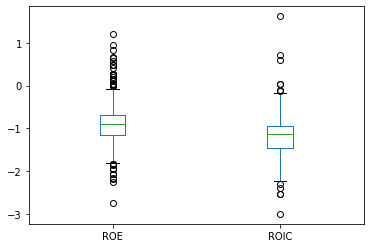

In [44]:
acoes_full[['ROE', 'ROIC']].apply(np.log10).plot.box()

<AxesSubplot:>

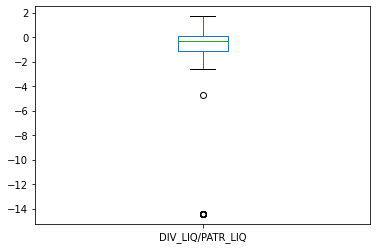

In [45]:
acoes_full[['DIV_LIQ/PATR_LIQ']].apply(np.log10).plot.box()

In [46]:
acoes_full[acoes_full['DIV_LIQ/PATR_LIQ'] == acoes_full['DIV_LIQ/PATR_LIQ'].min()]['DIV_LIQ/PATR_LIQ']

ticker
FRIO3   -28.235628
Name: DIV_LIQ/PATR_LIQ, dtype: float64

<AxesSubplot:>

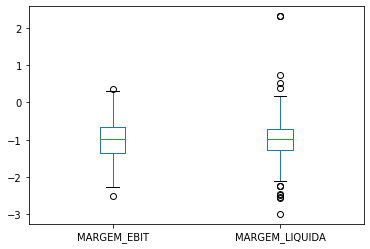

In [47]:
acoes_full[['MARGEM_EBIT', 'MARGEM_LIQUIDA']].apply(np.log10).plot.box()

# Testes de Hipótese

Serão analisadas as influências dos indicadores fundamentalistas citados acima

De acordo com a [Suno Research](https://www.sunoresearch.com.br/artigos/os-indicadores-mais-importantes-em-uma-analise/) uma boa **Margem Líquida**, por exemplo, em geral está acima de 10%

Abaixo serão testados os indicadores separando a população de acordo com o valor de 15% de **Margem Líquida**. A hipótese nula é de que essas duas populações tem médias de indicadores iguais, e a hipótese alternativa é de que para empresas de **ML** >= 15% esses indicadores tem média maior (no caso da Dívida Líquida/Patrimônio Líquido a hipótese alternativa é que é menor).

Será utilizado teste de Mann-Whitney já que a Margem Líquida não segue uma distribuição normal e serão comparados dois grupos não pariados

In [48]:
# Margem Líquida não segue uma distribuição normal
SIGNIFICANCIA = .01

print(f'MARGEM_LIQUIDA eh gaussiana: {stats.shapiro(acoes_full["MARGEM_LIQUIDA"]).pvalue > SIGNIFICANCIA}')
print()

ML_maior = acoes_full[acoes_full['MARGEM_LIQUIDA'] >= .15]
ML_menor = acoes_full[acoes_full['MARGEM_LIQUIDA'] < .15]

p_value_ROIC = stats.mannwhitneyu(ML_maior['ROIC'], ML_menor['ROIC'], alternative='greater').pvalue
p_value_ROE = stats.mannwhitneyu(ML_maior['ROE'], ML_menor['ROE'], alternative='greater').pvalue
p_value_DIVLIQ_PATLIQ = stats.mannwhitneyu(ML_maior['DIV_LIQ/PATR_LIQ'], ML_menor['DIV_LIQ/PATR_LIQ'], alternative='less').pvalue
p_value_MARGEM_EBIT = stats.mannwhitneyu(ML_maior['MARGEM_EBIT'], ML_menor['MARGEM_EBIT'], alternative='greater').pvalue

print(f'ROIC Hipótese nula: {"ACEITA" if p_value_ROIC > SIGNIFICANCIA else "REJEITADA"}')
print()
print(f'ROE Hipótese nula: {"ACEITA" if p_value_ROE > SIGNIFICANCIA else "REJEITADA"}')
print()
print(f'DIV_LIQ/PATR_LIQ Hipótese nula: {"ACEITA" if p_value_DIVLIQ_PATLIQ > SIGNIFICANCIA else "REJEITADA"}')
print()
print(f'MARGEM_EBIT Hipótese nula: {"ACEITA" if p_value_MARGEM_EBIT > SIGNIFICANCIA else "REJEITADA"}')


MARGEM_LIQUIDA eh gaussiana: False

ROIC Hipótese nula: REJEITADA

ROE Hipótese nula: REJEITADA

DIV_LIQ/PATR_LIQ Hipótese nula: REJEITADA

MARGEM_EBIT Hipótese nula: REJEITADA


Os indicadores considerados relevantes para saúde financeira se comportaram como esperado de acordo com os analistas do mercado financeiro.

# Parte 2

In [49]:
# quantos dias de negociação (dias uteis) tem nos 6 meses anteriores

len(history['ITSA4'].loc[_6m.date():TODAY.date()])

119

In [50]:
WINDOWS = [30, 90] # janelas de tempo em dias

def close_ema(row, window):
    return history[row.name]['close'].loc[_6m.date():TODAY.date()].ewm(span=window,adjust=False).mean().iloc[-1]

def close_std(row, window):
    return history[row.name]['close'].loc[_6m.date():TODAY.date()].rolling(window).std().iloc[-1]

def window_quantile(row, window, q):
    return history[row.name]['close'].loc[_6m.date():TODAY.date()].rolling(window).quantile(q).iloc[-1]

def all_time_high(row):
    return history[row.name]['close'].loc[:TODAY.date()].max()

def all_time_quantile(row, q):
    return history[row.name]['close'].loc[:TODAY.date()].quantile(q)

acoes_full['ALL_TIME_LOWER_QUARTILE'] = acoes_full.apply(all_time_quantile, args=(.25,), axis=1)
acoes_full['ALL_TIME_UPPER_QUARTILE'] = acoes_full.apply(all_time_quantile, args=(.75,), axis=1)
acoes_full['ALL_TIME_MEDIAN'] = acoes_full.apply(all_time_quantile, args=(.5,), axis=1)
acoes_full['ALL_TIME_HIGH'] = acoes_full.apply(all_time_high, axis=1)

for window in WINDOWS:
    acoes_full[f'{window}d_EMA'] = acoes_full.apply(close_ema, args=(window,), axis=1)
    acoes_full[f'{window}d_STD'] = acoes_full.apply(close_std, args=(window,), axis=1)
    acoes_full[f'{window}d_LOWER_QUARTILE'] = acoes_full.apply(window_quantile, args=(window, .25), axis=1)
    acoes_full[f'{window}d_UPPER_QUARTILE'] = acoes_full.apply(window_quantile, args=(window, .75), axis=1)
    acoes_full[f'{window}d_MEDIAN'] = acoes_full.apply(window_quantile, args=(window, .5), axis=1)


In [51]:
acoes_full.dropna(inplace=True)
acoes_full.shape

(435, 46)

In [52]:
acoes_full[[PRECO_HOJE, 'ALL_TIME_HIGH']
           + [col
              for col in acoes_full
              if col.endswith('_EMA') or col.endswith('_STD')
              or col.endswith('QUARTILE') or col.endswith('MEDIAN')]].head()
# TODO:
# feature percentis all-time [DONE]
# feature percentis window [DONE]
# discretizar target em percentis [DONE]

,PRECO_2020_04_15,ALL_TIME_HIGH,ALL_TIME_LOWER_QUARTILE,ALL_TIME_UPPER_QUARTILE,ALL_TIME_MEDIAN,30d_EMA,30d_STD,30d_LOWER_QUARTILE,30d_UPPER_QUARTILE,30d_MEDIAN,90d_EMA,90d_STD,90d_LOWER_QUARTILE,90d_UPPER_QUARTILE,90d_MEDIAN
ticker,,,,,,,,,,,,,,,
ABCB4,14.07,23.750000,8.319670,14.349300,9.835170,14.495609,2.060701,12.6825,14.137500,13.550000,17.096334,3.616854,14.445000,21.367500,19.719999
BAZA3,30.00,189.000000,26.000000,40.000000,32.000000,31.352450,3.248535,28.5000,31.622500,30.000000,34.342904,4.779336,32.097500,39.682499,37.475000
BBAS3,29.65,55.180000,9.495832,28.510000,22.481649,32.155390,5.795814,27.2300,31.715001,29.650000,39.850906,9.640486,32.950000,50.142501,48.644999
BBDC3,19.00,35.439999,3.404605,17.856899,11.621750,20.907360,2.775818,18.7100,20.485001,19.210000,25.879171,6.078261,20.897501,32.535001,31.570000
BBDC4,20.50,39.410000,14.751925,22.112575,17.392400,22.870859,3.213732,20.3977,23.142500,21.070001,28.001697,6.027746,23.812500,34.607500,33.314999


<AxesSubplot:>

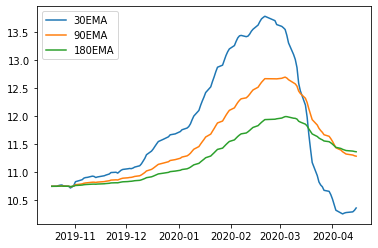

In [53]:
example = 'MGLU3'
s1 = history[example]['close'].loc[_6m.date():TODAY.date()].ewm(span=30,adjust=False).mean()
s2 = history[example]['close'].loc[_6m.date():TODAY.date()].ewm(span=90,adjust=False).mean()
s4 = history[example]['close'].loc[_6m.date():TODAY.date()].ewm(span=180,adjust=False).mean()
s3 = history[example]['close'].loc[_6m.date():TODAY.date()].rolling(30).quantile(.75)

pd.DataFrame({'30EMA': s1, '90EMA': s2, '180EMA': s4}).plot()

> Definindo target: variação do preço daqui a 90 pregões `"VARIACAO_90d"`

In [54]:
def target(row):
    d90_price = history[row.name]['close'].loc[:TODAY.date()].iloc[-1]
    target_price = history[row.name]['close'].iloc[-1]
    return target_price / d90_price - 1

prices = acoes_full.apply(lambda row: history[row.name]['close'].iloc[-1], axis=1)
    
     
acoes_full['VARIACAO_90d'] = acoes_full.apply(target, axis=1)

In [55]:
acoes_full.dtypes

ATIVO                       float64
DIV_BRUTA                   float64
DISPONIBILIDADES            float64
DIV_LIQUIDA                 float64
ATIVO_CIRCULANTE            float64
PATRIM_LIQ                  float64
RECEITA_LIQUIDA             float64
EBIT                        float64
LUCRO_LIQUIDO               float64
NRO_ACOES                   float64
CRES_REC_(5A)               float64
ROIC                        float64
LIQUIDEZ_CORR               float64
DEPOSITOS                   float64
CART_DE_CREDITO             float64
RESULT_INT_FINANC           float64
REC_SERVICOS                float64
PRECO_2020_04_15            float64
LPA                         float64
VPA                         float64
P/L                         float64
P/VP                        float64
P/EBIT                      float64
MARKET_CAP                  float64
EV                          float64
EV/EBIT                     float64
MARGEM_EBIT                 float64
MARGEM_LIQUIDA              

In [56]:
d90_price = history[example]['close'].loc[:TODAY.date()].iloc[-1]
target_price = history[example]['close'].iloc[-1]

acoes_full[acoes_full['VARIACAO_90d'] < 0]['VARIACAO_90d']

ticker
ABCB4   -0.130775
BEES3   -0.038462
BEES4   -0.065455
BGIP3   -0.136117
BNBR3   -0.106321
           ...   
VIVT4   -0.145972
VLID3   -0.065733
WHRL3   -0.248053
WHRL4   -0.241081
YDUQ3   -0.023198
Name: VARIACAO_90d, Length: 101, dtype: float64

In [57]:
acoes_full.dtypes

ATIVO                       float64
DIV_BRUTA                   float64
DISPONIBILIDADES            float64
DIV_LIQUIDA                 float64
ATIVO_CIRCULANTE            float64
PATRIM_LIQ                  float64
RECEITA_LIQUIDA             float64
EBIT                        float64
LUCRO_LIQUIDO               float64
NRO_ACOES                   float64
CRES_REC_(5A)               float64
ROIC                        float64
LIQUIDEZ_CORR               float64
DEPOSITOS                   float64
CART_DE_CREDITO             float64
RESULT_INT_FINANC           float64
REC_SERVICOS                float64
PRECO_2020_04_15            float64
LPA                         float64
VPA                         float64
P/L                         float64
P/VP                        float64
P/EBIT                      float64
MARKET_CAP                  float64
EV                          float64
EV/EBIT                     float64
MARGEM_EBIT                 float64
MARGEM_LIQUIDA              

> - Usando one-hot-encoding para dados categóricos
> - Separando o dataset em conjuntos de treinamento, validação e teste

In [58]:
X = pd.get_dummies(acoes_full.drop(columns=['VARIACAO_90d']))
y = acoes_full['VARIACAO_90d']

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)
_, X_val, _, y_val = train_test_split(X, y, test_size=.25, random_state=0)

print(len(X_train), len(X_test), len(X_val))

326 109 109


> Utilizando optuna para escolha dos hiperparâmetros

In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import os
import joblib
import optuna

def objective(trial):
    reg_name = trial.suggest_categorical('regressor', ['SVM', 'RandomForest', 'MLP'])
    
    if reg_name == 'SVM':
        hyperparams = {
            'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
            'degree': trial.suggest_int('degree', 3, 10),
            'C': trial.suggest_loguniform('C', 1e-10, 1e10),
            'gamma': 'auto'
        }
        regr = make_pipeline(StandardScaler(), SVR(**hyperparams))


    elif reg_name == 'RandomForest':
        hyperparams = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200, 50),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
            'n_jobs': -1,
            'random_state': 42
        }
        regr = RandomForestRegressor(**hyperparams)


    elif reg_name == 'MLP':
        n_layers = trial.suggest_int('n_layers', 1, 3)
        layers = []
        for i in range(n_layers):
            layers.append(int(trial.suggest_discrete_uniform(f'n_neurons_{i}', 50, 100, 10)))

        hyperparams = {
            'hidden_layer_sizes': tuple(layers),
            'activation': trial.suggest_categorical('activation', ['logistic', 'tanh']),
            'max_iter': 10**4,
            'random_state': 42,
            'solver': 'lbfgs'
        }
        regr = MLPRegressor(**hyperparams)
        
    regr.fit(X_train, y_train)
    
    y_pred = regr.predict(X_val)
    
    return np.sqrt(mean_squared_error(y_val, y_pred))

In [61]:
%%time

study_path = '../data/study.pkl'
if os.path.exists(study_path) and os.path.isfile(study_path):
    study = joblib.load(study_path)
else:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50, n_jobs=-1, timeout=60 * 60)
    joblib.dump(study, study_path)

CPU times: user 15.4 ms, sys: 0 ns, total: 15.4 ms
Wall time: 14.2 ms


In [62]:
study.best_params

{'regressor': 'MLP',
 'n_layers': 3,
 'n_neurons_0': 100.0,
 'n_neurons_1': 70.0,
 'n_neurons_2': 70.0,
 'activation': 'logistic'}

> Adicionando MLFlow para log dos algoritmos

In [63]:
import mlflow

mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment("IF697")
mlflow.sklearn.autolog()

> Função para pegar os melhores hiperparametros baseado no estudo feito no optuna

In [64]:
def get_best_hyperparams(regr_type: str) -> dict:
    best_hyperparams = None
    best_rmse = np.inf

    for t in study.get_trials():
        if t.params['regressor'] == regr_type:
            if best_rmse > t.value:
                best_rmse = t.value
                best_hyperparams = t.params.copy()

    del best_hyperparams['regressor']

    if regr_type == 'MLP':
        n_layers = best_hyperparams['n_layers']
        del best_hyperparams['n_layers']
        
        layers = [0 for i in range(n_layers)]
        
        for k, v in list(best_hyperparams.items()):
            if k.startswith('n_neurons_'):
                layers[int(k.split('_')[-1])] = int(v)
                del best_hyperparams[k]
                
        best_hyperparams['hidden_layer_sizes'] = tuple(layers)
    
    return best_hyperparams

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

## Os 4 algoritmos escolhidos foram:

- Regressão Linear, o algoritmo de regressão mais básico que vai servir de comparativo para os outros algoritmos
- SVM, com diferentes kernels
- Random Forest
- MLP, com diferentes combinações de camadas

# Regressão Linear

baseline de comparação para os outros regressores

In [65]:
lr_hyperparams = {
    'normalize': True,
    'n_jobs': -1
}


with mlflow.start_run(run_name=f'lr_{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}') as run:
    lr = LinearRegression(**lr_hyperparams).fit(X_train, y_train)

    y_pred = lr.predict(X_test)

    (rmse, mae, r2) = eval_metrics(y_test, y_pred)

    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    
    print("rmse: %.3f" % rmse)
    print("r2: %.3f" % r2)
    print("mae: %.3f" % mae)


rmse: 658941131182.627
r2: -702110496331977612853248.000
mae: 190909877102.489


# SVM

In [66]:
svm_hyperparams = {
    'gamma': 'auto',
    **get_best_hyperparams('SVM')
}

print(svm_hyperparams)

with mlflow.start_run(run_name=f'svm_{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}') as run:

    svr = make_pipeline(StandardScaler(), SVR(**svm_hyperparams))

    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)

    (rmse, mae, r2) = eval_metrics(y_test, y_pred)

    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    
    print("rmse: %.3f" % rmse)
    print("r2: %.3f" % r2)
    print("mae: %.3f" % mae)


2020/11/17 12:13:06 WARNING mlflow.sklearn.utils: Truncated the value of the key `steps`. Truncated value: `[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svr', SVR(C=0.061688259325117706, cache_size=200, coef0=0.0, degree=4, epsilon=0.1,
    gamma='auto', kernel='sigmoid', max_iter=-1, shrinking=True, tol=0.001,
    ve...`


{'gamma': 'auto', 'kernel': 'sigmoid', 'degree': 4, 'C': 0.061688259325117706}
rmse: 0.793
r2: -0.016
mae: 0.374


# Random Forest

In [67]:
rf_hyperparams = {
    'n_jobs': -1,
    'random_state': 42,
    **get_best_hyperparams('RandomForest')
}

print(rf_hyperparams)

rf = RandomForestRegressor(**rf_hyperparams)

with mlflow.start_run(run_name=f'r_forest_{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}') as run:
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    (rmse, mae, r2) = eval_metrics(y_test, y_pred)

    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    
    print("rmse: %.3f" % rmse)
    print("r2: %.3f" % r2)
    print("mae: %.3f" % mae)


{'n_jobs': -1, 'random_state': 42, 'n_estimators': 50, 'min_samples_leaf': 1}
rmse: 0.949
r2: -0.457
mae: 0.453


# MLP

In [68]:
%%time

mlp_hyperparams = {
    'max_iter': 10**4,
    'random_state': 42,
    'solver': 'lbfgs',
    **get_best_hyperparams('MLP')
}

mlp_hyperparams

print(mlp_hyperparams)

mlp = MLPRegressor(**mlp_hyperparams)

with mlflow.start_run(run_name=f'mlp_{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}') as run:
    mlp.fit(X_train, y_train)
    
    y_pred = mlp.predict(X_test)

    (rmse, mae, r2) = eval_metrics(y_test, y_pred)

    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    
    print("rmse: %.3f" % rmse)
    print("r2: %.3f" % r2)
    print("mae: %.3f" % mae)


{'max_iter': 10000, 'random_state': 42, 'solver': 'lbfgs', 'activation': 'logistic', 'hidden_layer_sizes': (100, 70, 70)}
rmse: 0.815
r2: -0.073
mae: 0.406
CPU times: user 2min 48s, sys: 4min 8s, total: 6min 57s
Wall time: 39.2 s


> É possível observar através do MLFlow que a SVM obteve melhor desempenho em todas as métricas em relação aos demais e o MLP não ficou muito atrás, uma diferença muito pequena

> Todos eles obtiveram um desempenho muito superior à regressão linear

# Melhoria do algoritmo com melhor desempenho

In [69]:
print(f'Temos: {len(X.columns)} atributos')

Temos: 162 atributos


In [70]:
from sklearn.decomposition import PCA

In [71]:
pca = PCA(n_components=50, svd_solver='randomized',
          whiten=True, random_state=42)
pca.fit(X_train)

2020/11/17 12:13:46 WARNING mlflow.sklearn: PCA.score failed. The 'training_score' metric will not be recorded. Scoring error: 'y'


PCA(copy=True, iterated_power='auto', n_components=50, random_state=42,
    svd_solver='randomized', tol=0.0, whiten=True)

In [72]:
X_pca_train = pca.transform(X_train)
X_pca_test = pca.transform(X_test)

In [73]:
X_pca_train.shape

(326, 50)

In [74]:
with mlflow.start_run(run_name=f'svm_pca_{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}') as run:
    svr.fit(X_pca_train, y_train)
    y_pred = svr.predict(X_pca_test)

    (rmse, mae, r2) = eval_metrics(y_test, y_pred)

    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    
    print("rmse: %.3f" % rmse)
    print("r2: %.3f" % r2)
    print("mae: %.3f" % mae)


2020/11/17 12:13:46 WARNING mlflow.sklearn.utils: Truncated the value of the key `steps`. Truncated value: `[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svr', SVR(C=0.061688259325117706, cache_size=200, coef0=0.0, degree=4, epsilon=0.1,
    gamma='auto', kernel='sigmoid', max_iter=-1, shrinking=True, tol=0.001,
    ve...`


rmse: 0.807
r2: -0.054
mae: 0.387


> Redução de dimensionalidade com o PCA não surtiu nenhum efeito positivo na SVM

> Utilizando ensemble com os regressores testados há uma melhora em relação aos algoritmos vistos anteriormente em todas as métricas exceto erro médio absoluto (mae)

In [75]:
from sklearn.ensemble import VotingRegressor

estimators = [('SVM', svr), ('RandomForest', rf), ('MLP', mlp)]

weights = (1.5, .3, .3)

regr = VotingRegressor(estimators, weights, n_jobs=-1)

with mlflow.start_run(run_name=f'ensemble_{str(weights)}_{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}') as run:
    regr.fit(X_train, y_train)

    y_pred = regr.predict(X_test)

    (rmse, mae, r2) = eval_metrics(y_test, y_pred)

    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    
    print("rmse: %.3f" % rmse)
    print("r2: %.3f" % r2)
    print("mae: %.3f" % mae)

2020/11/17 12:13:47 WARNING mlflow.sklearn.utils: Truncated the value of the key `estimators`. Truncated value: `[('SVM', Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=0.061688259325117706, cache_size=200, coef0=0.0,
         ...`
2020/11/17 12:13:47 WARNING mlflow.sklearn.utils: Truncated the value of the key `SVM`. Truncated value: `Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=0.061688259325117706, cache_size=200, coef0=0.0,
                  ...`
2020/11/17 12:13:47 WARNING mlflow.sklearn.utils: Truncated the value of the key `RandomForest`. Truncated value: `RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
            

rmse: 0.788
r2: -0.004
mae: 0.378


/home/adilson/.anaconda3/envs/if697/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='ticker'>

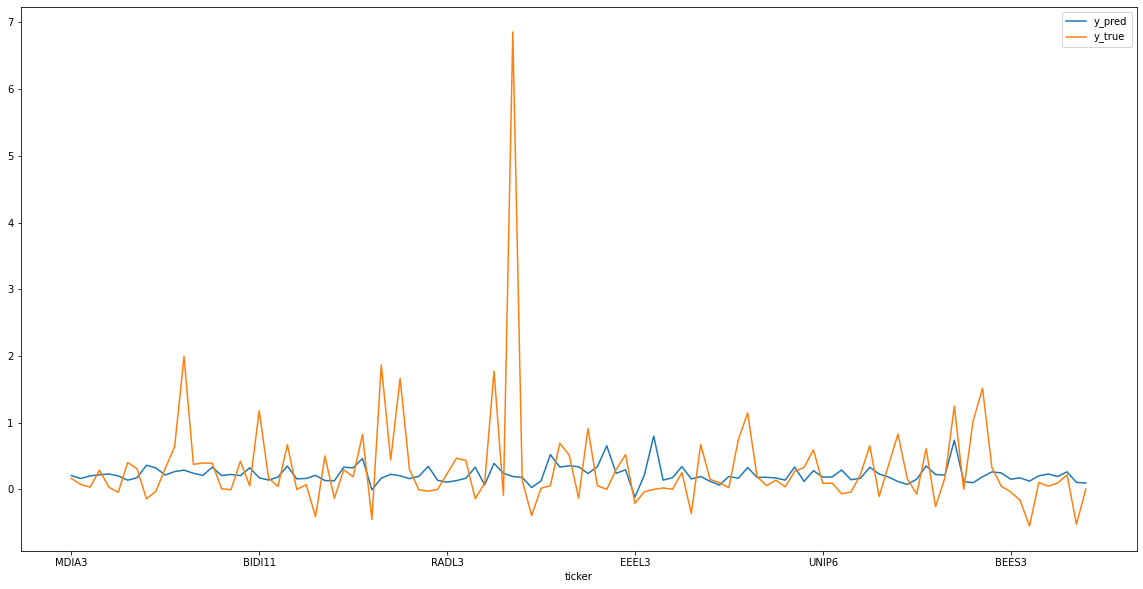

In [76]:
pd.DataFrame({'y_pred': y_pred, 'y_true': y_test}).plot(figsize=(20, 10))

> Com a remoção de outliers do conjunto de treinamento abaixo, é possível observar uma melhora no erro médio absoluto; Por enquanto o melhor modelo obtido

In [77]:
Q1 = y_train.quantile(0.25)
Q3 = y_train.quantile(0.75)
IQR = Q3 - Q1

fltr = (y_train >= Q1 - 1.5 * IQR) & (y_train <= Q3 + 1.5 *IQR)

In [78]:
y_noout_train = y_train.loc[fltr]
X_noout_train = X_train.loc[fltr]

with mlflow.start_run(run_name=f'ensemble_remove_outlier_{str(weights)}_{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}') as run:
    regr.fit(X_noout_train, y_noout_train)

    y_pred = regr.predict(X_test)

    (rmse, mae, r2) = eval_metrics(y_test, y_pred)

    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    
    print("rmse: %.3f" % rmse)
    print("r2: %.3f" % r2)
    print("mae: %.3f" % mae)

2020/11/17 12:13:59 WARNING mlflow.sklearn.utils: Truncated the value of the key `estimators`. Truncated value: `[('SVM', Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=0.061688259325117706, cache_size=200, coef0=0.0,
         ...`
2020/11/17 12:13:59 WARNING mlflow.sklearn.utils: Truncated the value of the key `SVM`. Truncated value: `Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=0.061688259325117706, cache_size=200, coef0=0.0,
                  ...`
2020/11/17 12:13:59 WARNING mlflow.sklearn.utils: Truncated the value of the key `RandomForest`. Truncated value: `RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
            

rmse: 0.788
r2: -0.004
mae: 0.350


/home/adilson/.anaconda3/envs/if697/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='ticker'>

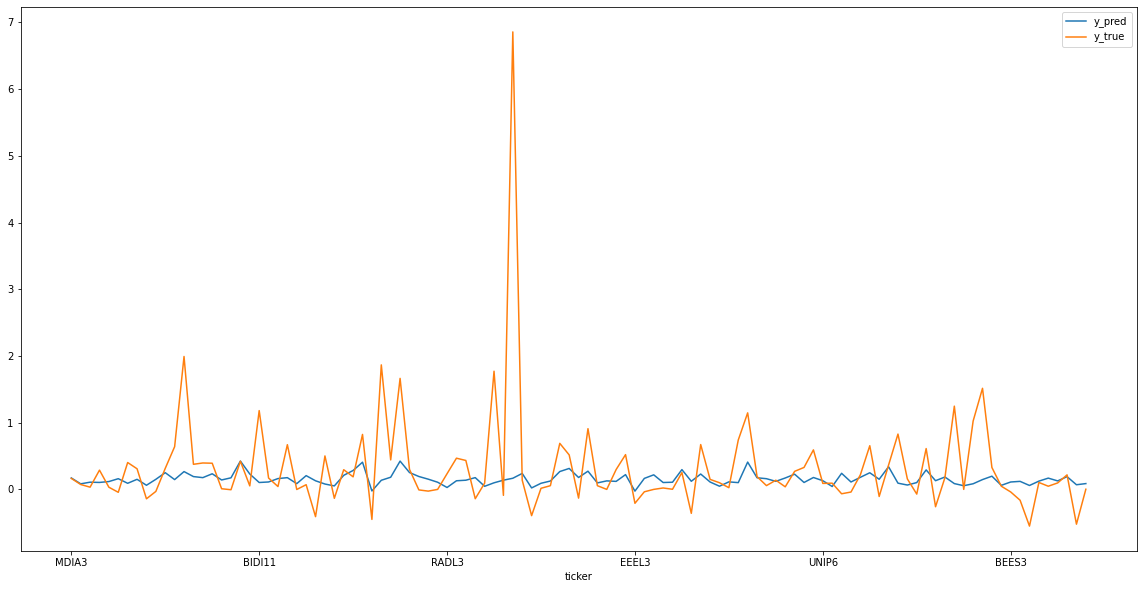

In [79]:
pd.DataFrame({'y_pred': y_pred, 'y_true': y_test}).plot(figsize=(20, 10))